In [1]:
#@title File Locations
base_dir = "" #@param {type:"string"}
state_param_file = "data/us-wa/wa_state_parameters_transpose.csv" #@param {type:"string"}
county_households_file = "data/us-wa/wa_county_household_demographics.csv" #@param {type:"string"}
county_params_file = "data/us-wa/wa_county_parameters.csv" #@param {type:"string"}
county_occupation_file = "data/us-wa/wa_county_occupation_networks.csv"  #@param {type:"string"}
import os
if base_dir:
  state_param_file = os.path.join(base_dir, state_param_file)
  county_households_file = os.path.join(base_dir, county_households_file)
  county_params_file = os.path.join(base_dir, county_params_file)
  county_occupation_file = os.path.join(base_dir, county_occupation_file)

In [41]:
import collections
import sys
import example_utils as utils
import pandas as pd
import numpy as np
import csv
LOCAL_PARAMS = set(["county_fips", "lockdown_days", "app_turned_on"])

def bucket_to_age(b):
  return int(b.split("_")[1]) // 10

def read_param_file(file_name):
  params = {}
  pf = pd.read_csv(file_name,skipinitialspace=True, comment="#")
  if "transpose" in file_name:
    for row in pf.itertuples():
      params[row.parameter_name] = row.parameter_value
  else:
    for row in pf.itertuples():
      params.update(row.as_dict())
  return params

def read_param_files(file_names):
  params = {}
  for f in file_names:
    params.update(read_param_file(f))
  return params

def build_population(params_dict, houses):
  IDs = np.arange( params_dict["n_total"], dtype='int32')
  house_no = np.zeros( IDs.shape, dtype='int32' )
  ages     = np.zeros( IDs.shape , dtype='int32' )
  idx = 0
  house_idx = 0
  for house in houses.itertuples():
    house_pop = 0
    for col in houses.columns:
      if col.startswith("a_"):
        age = bucket_to_age(col)
        cnt = int(getattr(house,col))
        if cnt == 0:
          continue
        house_pop += cnt
        house_no[idx:idx+cnt] = house_idx
        ages[idx:idx+cnt] = age
        idx += cnt
    if house_pop != 0:
      house_idx += 1
  return pd.DataFrame({'ID':IDs, 'age_group':ages, 'house_no':house_no})

def read_county_occupation_network( county_fips, all_occupations ):
  sector_df = all_occupations[all_occupations.area_fips == county_fips]
  sector_name = sector_df['industry_code'].values
  sector_size = sector_df['qrtly_emplvl'].values
  sector_pdf = sector_size / np.sum( sector_size )
  return list( sector_name ), list( sector_pdf )

def get_mean_work_interaction( params, age_type ):
  if age_type == 0:
    return params.get_param( 'mean_work_interactions_child' )
  elif age_type == 1:
    return params.get_param( 'mean_work_interactions_adult' )
  elif age_type == 2:
    return params.get_param( 'mean_work_interactions_elderly' )
  else:
    raise ValueError( 'not supported age type' )

def get_lockdown_multipliers( params, n_networks ):
  # For now, just use default lockdown_multipliers.
  lockdown_multiplier = np.ones( n_networks ) * params.get_param('lockdown_occupation_multiplier_working_network')
  lockdown_multiplier[0] = params.get_param('lockdown_occupation_multiplier_primary_network')
  lockdown_multiplier[1] = params.get_param('lockdown_occupation_multiplier_secondary_network')
  lockdown_multiplier[-2] = params.get_param('lockdown_occupation_multiplier_retired_network')
  lockdown_multiplier[-1] = params.get_param('lockdown_occupation_multiplier_elderly_network')
  return lockdown_multiplier

def build_occupation_networks( params, sector_names, n_child_network=2, n_elderly_network=2 ):
  n_networks = n_child_network + len( sector_names ) + n_elderly_network
  network_no = np.arange( n_networks, dtype='int32' )
  network_names = ['primary', 'secondary'] + sector_names + ['retired', 'elderly']
  age_types = np.ones( n_networks )
  age_types[:2] = 0 # child
  age_types[-2:] = 2 # elderly
  mean_work_interactions = map( lambda x: get_mean_work_interaction(params, x), 
                                age_types )
                                              
  return pd.DataFrame({
      'network_no': network_no,
      'age_type': age_types,
      'mean_work_interaction': mean_work_interactions,
      'lockdown_multiplier': get_lockdown_multipliers( params, n_networks ),
      'network_id' : network_no,
      'network_name': network_names
  })

def build_occupation_assignment(household_df, network_df, network_pdf):
  IDs = household_df.ID.values
  age_groups = household_df.age_group.values

  # assign adult workplace networks
  sector_ids = network_df[network_df.age_type == 1].network_no.values
  assignment = np.random.choice(sector_ids, len(IDs), p=network_pdf)

  # assign child and elderly networks
  assignment[age_groups == 0] = 0 # primary_network
  assignment[age_groups == 1] = 1 # secondary_network
  assignment[age_groups == 7] = np.max(sector_ids) + 1 # retired_network
  assignment[age_groups == 8] = np.max(sector_ids) + 2 # elderly_network

  return pd.DataFrame({'ID': IDs, 'network_no': assignment})

def run_model(params_dict, houses, sector_names, sector_pdf, custom_occu_network ):
  total_days_left = int(params_dict['end_time'])

  params  = utils.get_baseline_parameters()
  for p, v in params_dict.items():
    if p == 'manual_trace_n_workers':
      continue
    if p in LOCAL_PARAMS:
      continue
    if isinstance(v, np.int64) or (hasattr(v, "is_integer") and v.is_integer()):
      params.set_param( p, int(v) )
    else:
      params.set_param( p, v )
  
  hh_df = build_population( params_dict, houses )
  params.set_demographic_household_table( hh_df )
  if custom_occu_network:
    occupation_network_df = build_occupation_networks( params, 
                                                       sector_names )
  
    occupation_assignment = build_occupation_assignment( hh_df, 
                                                         occupation_network_df, 
                                                         sector_pdf )
    params.set_occupation_network_table( occupation_assignment, 
                                         occupation_network_df )

  model = utils.get_simulation( params ).env.model

  m_out = []
  model.one_time_step()
  m_out.append(model.one_time_step_results())
  total_days_left -= 1
  while m_out[-1]["total_infected"] < params_dict["n_total"] * 0.01:
      model.one_time_step()
      m_out.append(model.one_time_step_results())
      total_days_left -= 1

  params_dict["time_offset"] = params_dict['end_time'] - total_days_left

  model.update_running_params("lockdown_on", 1)
          
  for step in range(total_days_left):
      if step == params_dict['lockdown_days']:
          model.update_running_params("lockdown_on", 0)
          
      model.one_time_step()
      m_out.append(model.one_time_step_results())

  df = pd.DataFrame( m_out )
  m_out = []
  del model
  return params_dict, df

def run_counties(county_params, all_households, all_occupations, params_files=[], params_overrides={}, counties=None, custom_occu_network=True):
  if counties is None:
    counties = county_params.county_fips.unique()
  base_params = params_overrides
  base_params.update(read_param_files(params_files))
  outputs = []
  for county in counties[:1]:
    params = base_params.copy()
    params.update(county_params[county_params["county_fips"] == county].iloc[0])
    households = all_households[all_households["county_fips"] == county]
    sector_names, sector_pdf = read_county_occupation_network(county, all_occupations)
    outputs.append(run_model(params, households, sector_names, sector_pdf, custom_occu_network))
  return outputs

In [4]:
all_households = pd.read_csv(county_households_file)
county_params = pd.read_csv(county_params_file)
counties = county_params.county_fips.unique()
all_occupations = pd.read_csv(county_occupation_file)

In [5]:
local_params = {
    "lockdown_days": 35,
    "app_turned_on": 1,
}

In [42]:
results_default = run_counties(county_params, all_households, all_occupations, params_files=[state_param_file], params_overrides=local_params, counties=counties[:1], custom_occu_network=False)
results_custom_occu = run_counties(county_params, all_households, all_occupations, params_files=[state_param_file], params_overrides=local_params, counties=counties[:1], custom_occu_network=True)

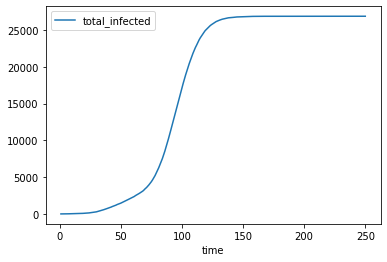

In [43]:
results_default[0][1].plot(x='time', y='total_infected')

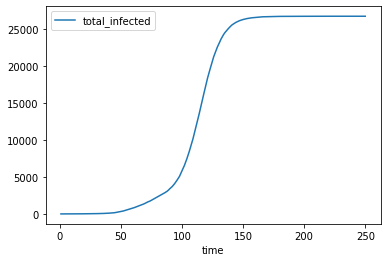

In [44]:
results_custom_occu[0][1].plot(x='time', y='total_infected')

In [45]:
np.where(results_default[0][1].lockdown == 1), np.where(results_custom_occu[0][1].lockdown == 1)

((array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67]),),
 (array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
         70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
         87]),))